<a id='introduction'></a> 
# INTRODUCTION

In [1]:
#%matplotlib inline
#%matplotlib notebook
# Imports

import urllib.request
import numpy as np
import pandas
import datetime
import os
import cdflib
import cdflib.epochs as epoch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tdscdf as loader # also contains other functions from this notebook


<a id='descriptions'></a> 
## Brief descriptions

### 1. RPW/TDS block diagram

<img src=./Pictures/solo_tds_block.png  width=90%>    
<br>

### 2. Spacecraft Reference Frame (SRF)

<br>
<img src=./Pictures/SRF.png  width=70%>    
<br>




<a id='data'></a> 
## Data functions  

In [2]:
# Convering to SRF
def convert_to_SRF(data, index=0):
    """ 
        Convert TDS SWF from the antenna to the spacecraft 
        reference frame (SRF).
        Using the effective antenna directions
        two components of the E-field in the Y-Z SRF plane
        are calculated for the given TDS configuration.
        data(ncomp, nsamples) - input array 2-D vectors of the electric field expressed in the
                    ANT coordinate system in V/m
        index - a snapshot number to be transformed, the first is default
        E(2,nsamples) - 2D E-field E[0, *] = Ey, E[1, *] = Ez
    """
    nsamp = data['SAMPS_PER_CH'][index]
    tds_mode = data['TDS_CONFIG_LABEL'][index]
    if 'SE1' in tds_mode:
        # Pachenko's antenna angle
        pacang = np.deg2rad(125)
        V1 = [0, 1]
        # Pachenko monopole antennas
        V2 = [np.sin(pacang), np.cos(pacang)]
        V3 = [-np.sin(pacang), np.cos(pacang)]
        # SE1 TDS mode
        M = np.array([V1, V2])  # [CH1, CH2]
    else:
        pacang = np.deg2rad(158.1)
        ant21 = [np.sin(pacang), np.cos(pacang)]  # E - field in the same sense.
        pacang = np.deg2rad(-158.2)
        ant13 = [-np.sin(pacang), -np.cos(pacang)]  # ant31 then - 1. to ant13
        M = np.array([ant13, ant21])  # [CH1, CH2]

    ww = data['WAVEFORM_DATA'][index, :, 0:nsamp]
    # projection: E = MAT(ANT->SRF) * V; where MAT(2,2) and V is observed field
    M = np.linalg.inv(M)
    E = np.dot(M, ww[0:2, :]) * 1e3  # transformation into SRF (Y-Z) in (mV/m)
    return E


loading solo_L2_rpw-tds-surv-tswf-e-cdag_20211009_V06.cdf


In [10]:
# Waveform plot
def plot_waveform(ww, t0, sr):
    """
        Plotting the TDS-TSWF waveform snapshots
    """
    nsamp = int(ww.size/2)
    timestr = t0.item().strftime('%Y/%m/%d, %H:%M:%S.%f')
    tt = np.arange(0, nsamp/sr, 1/sr)*1e3
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=80)
    ax1.plot(tt,ww[0, :])
    ax1.set(ylabel='$EY_{SRF}$ (mV/m)')
    
    ax2.plot(tt,ww[1, :])
    ax2.set(ylabel='$EZ_{SRF}$ (mV/m)')
    plt.xlabel('Time since trigger (ms)')
    plt.suptitle(('TDS-TSWF waveforms in SRF: %s SWF#%d' % (timestr, rec)))
    plt.xlim(0, nsamp/sr*1e3)
    plt.show()

    
# Spectrum
def plot_spectrum(ww, t0, sr):
    """
        Plotting the TDS-TSWF spectra computed from Ey and Ez SRF 
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    tt = np.arange(0, nsamp/sr, 1/sr)
    fourier_transform = np.fft.rfft(ww)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sr / 2, len(power_spectrum[0,:]))
    xmin = (np.abs(frequency - 200)).argmin()
    if sr>300000:
        fmax = 200000
    else:
        fmax = 100000
    xmax = (np.abs(frequency - fmax)).argmin()
    
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[0, xmin:xmax])
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[1, xmin:xmax])
    plt.legend(['$EY_{SRF}$','$EZ_{SRF}$'])
    
    plt.yscale("log")
    plt.xlim(2, fmax*1e-3)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Power spectral density')
    timestr = t0
    plt.title(('SolO TDS TSWF spectrum  %s SWF#%d' % (timestr, rec)))
    

# Hodogram
def plot_hodogram(ww, t0, size=200, samp=-1):
    """
        Plotting a hodogram from Ey-Ez components 
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    if samp == -1:
        amp = np.abs(ww[0, :]) + np.abs(ww[1, :])
        samp = np.argmax(amp)
        if samp<size/2:
            samp = 251
        elif samp>nsamp-(size/2):
            samp = nsamp-251

    if samp < size / 2:
        samp = size + 1
    elif samp > nsamp - (size / 2):
        samp = nsamp - size - 1

    y = ww[0, int(samp-size):int(samp+size/2)]
    z = ww[1, int(samp-size):int(samp+size/2)]
    
    plt.plot(y,z)
    m = ww.max()*1.1
    plt.gca().set_aspect('equal')
    plt.xlim(-m,m)
    plt.ylim(-m,m)
    plt.xlabel('$EY_{SRF}$ (mV/m)')
    plt.ylabel('$EZ_{SRF}$ (mV/m)')
    timestr = t0
    plt.title(('SolO TDS TSWF hodogram %s SWF#%d' % (timestr, rec)))
    plt.show()
    

# Examples

## Download, load cdf file and convert waveforms into SRF

In [13]:
"""
    Downloading TDS-SURV-TSWF cdf file for a given date.
    !! The file might have a size of several hundreds of MB
"""
date = (2021,10,9)
tswf = loader.load_data(date product='surv-tswf') # Downloads from SOAR archive

ww = convert_to_SRF(tswf, 0) # Converts the first snapshot to SRF

loading solo_L2_rpw-tds-surv-tswf-e-cdag_20211009_V06.cdf


## Plot waveform

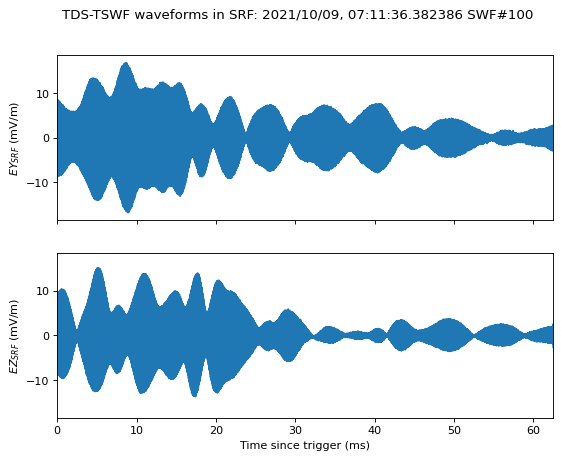

In [19]:
# Waveform plot
"""
    Plot TDS-TSWF snapshot
    Select snaphost #100, do conversion ANT->SRF coordinates, !! only Y, Z components !!
    Plot waveform
"""
rec = 100 # snapshot #101

ww = convert_to_SRF(tswf, rec)
t0 = cdflib.epochs.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_waveform(ww, t0, sr)

## Plot spectrum

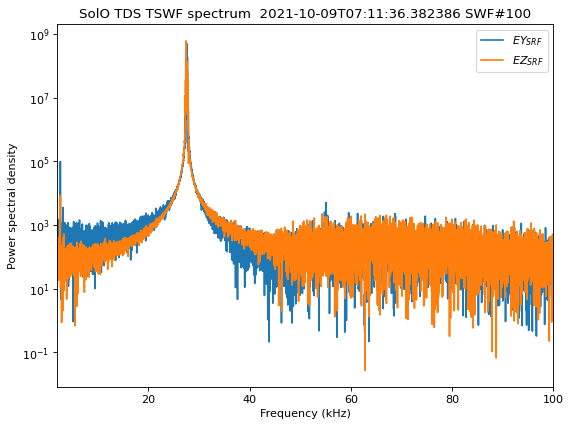

In [20]:
# Spectrum plot
"""
    Plot TDS-TSWF snapshot
    Select snaphost #100, do conversion ANT->SRF coordinates, !! only Y, Z components !!
    Plot spectrum for both Y_SRF and Z_SRF components
"""
rec = 100 # snapshot #101

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]

plot_spectrum(ww, t0, sr)

## Plot hodogram


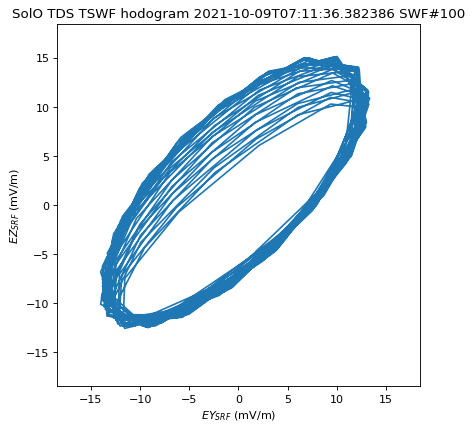

In [21]:
# Hodogram plot
"""
    Plot TDS-TSWF snapshot hodogram, i.e. E-field Y vs. Z
    Select snaphost #100, do conversion ANT->SRF coordinates, !! only Y, Z components !!
    Plot hodogram
"""
rec = 100 # snapshot #101

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_hodogram(ww, t0) # snapshot 100, length = 200 (default), center chosen at maximum

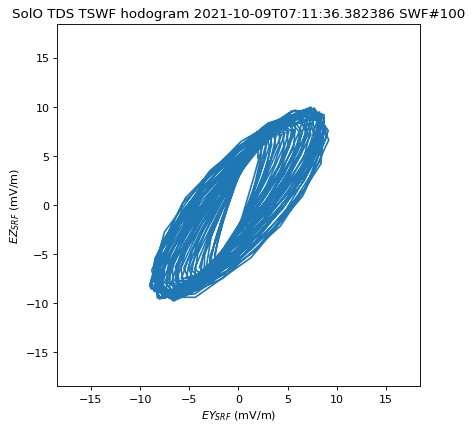

In [22]:
# Manual Hodogram plot
"""
    Plot TDS-TSWF snapshot snippet hodogram, i.e. E-field Y vs. Z
    Select snaphost #100, do conversion ANT->SRF coordinates, !! only Y, Z components !!
    Plot hodogram
"""
rec = 100 # snapshot #101

ww = convert_to_SRF(tswf, rec)
t0 = epoch.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
sr = tswf['SAMPLING_RATE'][rec]


plot_hodogram(ww, t0, 300, 6000) # snapshot 100, length 300, center 6000